# 01 - Project Introduction: *Case study region and its seasonal patterns*

In [ ]:
# Basic imports
import numpy as np
import pandas as pd

# Plotting packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Geodata handlers
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping, Polygon

import cmasher as cmr
from visualization.custom_plots import day_of_year_to_date, standard_format_single

# Set the default font size for the plots
font = {'weight' : 'normal',
        'size'   : 9}

matplotlib.rc('font', **font)

## Case study region
The study area analyzed in this work is the Indian subcontinent with a focus on the Hindu-Kush Karakoram/Himalaya region (HKKH).

As we will see later the interesting features of this area are:
- Two different seasonal patterns are detectable in the same region.
- The features of one of the two seasonal pattern, the Indian Summer Monsoon, are deeply exploited in scientific literature. This gives us a strong stsrting point for evaluating a machine learning algorithm which aims to detect the meteorological seasons.



--- 
### Boundaries data
The **administrative boundary data** are taken from [GADM](https://gadm.org/about.html), version 4.1. Data are distributed in GeoPackage format. Two different files are used:
- World: contains the first level (countries) for the entire world (*data/raw/external/GADM41_WORLD.gpkg*)
- India: contains the four administration levels of India (*data/raw/external/GADM41_IND.gpkg*)

The *administrative division of India* follows this scheme:
- Level 0: Country
- Level 1: States and union territories
- Level 2: District
- Level 3: Taluc

<sub><sup> *DISCLAIMER: Some regions in this area are disputed between states. The authors do not take responsibility for the borders shown, which are sourced from the GADM dataset.* </sup></sub>

The **regional data** for the Hindu Kush-Karakoram/Himalayas region are tacken from Palazzi et al, 2012


In [2]:
# -- BOUNDARIES DATA
# Geopackages with boundaries
country_boundary_file   = '../data/preprocessed/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1') # Layer 1 -> states
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')       # Layer 0 -> countries

# Clipping the world boundary to the Indian subcontinent
xmin, xmax, ymin, ymax = 65, 100, 5, 40

# Selection box
selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
world_boundary = gpd.clip(world_boundary, selection_box)

# Save clipped shapefile
world_boundary.to_file("../data/preprocessed/external/GADM41_WORLD_clip.gpkg")

# Defining the custom regions (based on Palazzi et al, 2012)
hkk_region = gpd.GeoDataFrame({'geometry': [Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])], 'short_name': 'hkk', 'long_name': 'Hindu Kush-Karakoram'}, crs=world_boundary.crs)
him_region = gpd.GeoDataFrame({'geometry': [Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])], 'short_name': 'him', 'long_name': 'Himalayas'}, crs=world_boundary.crs)

HKKH = pd.concat([hkk_region, him_region])
HKKH.to_file("../data/preprocessed/external/HKKH.gpkg")

--- 
### Orography data

The region exhibits complex orography, notably characterized by the Himalayan mountains in the northwest. The orography data utilized is sourced from ERA5, imported in the form of geopotential heights and converted into meters by dividing by 9.81. Additionally, the data is masked using `world_boundary` to exclude sea points.

In [ ]:
#-- OROGRAPHY
# NetCDF file
orography_data_path     = '../data/raw/ERA5/static/ERA5_LAND_orog.nc'

# Importing as xarray dataset
orography = xr.open_dataset(orography_data_path)

# Masking the dataset to remove sea points
orography = orography.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
orography.rio.write_crs("epsg:4326", inplace=True)
orography = orography.rio.clip(world_boundary.geometry.apply(mapping), world_boundary.crs, drop=True)

# Computing elevations from geopotential - time[0] is selected to remove dummy time dimension
orography = orography.z.isel(time=0).rename('Elevation [km]') / (9.81*1000)

/home/jgrassi/miniconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


--- 
### Plotting the case study region



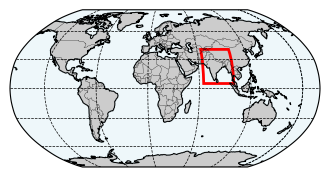

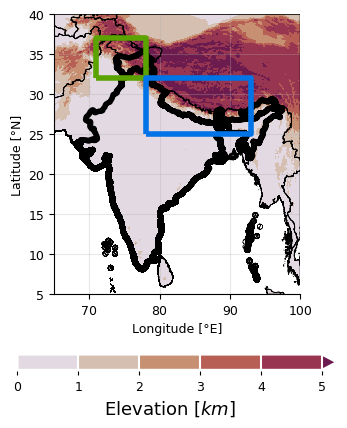

In [4]:
cmap = cmr.get_sub_cmap('twilight_shifted', 0.5, 0.89)

# Creating the figure 1 for the global map
fig_1 = plt.figure(figsize=(4, 4))

# Adding subplot with global map
ax = fig_1.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=20.0))
ax.set_global()
ax.coastlines(lw=0.7)
ax.add_feature(cfeature.BORDERS, linestyle='-', lw=0.2)
ax.add_feature(cfeature.LAND, color='gray', alpha=0.4)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)

# Add latitude and longitude grid lines
gl = ax.gridlines(draw_labels=False, linestyle='--', color='k', lw=0.5)


# Creating the figure 2 for the submaps
fig = plt.figure(figsize=(4, 4))
# Define extent of case study regions
regions = {
    "India": [65, 100, 5, 40],
}

# Function for adding sub-map
def add_inset(extent, loc, orography, levels, ax_to_hide):

    # Cutting orography in the right extent
    orog = orography.sel(latitude = slice(extent[3], extent[2]), longitude = slice(extent[0], extent[1]))
    orog = np.abs(orog)

    # Creating ax for sub map
    sub_ax = fig.add_axes(loc)

    # Plotting orography in submap
    orog_plot = orog.plot(ax=sub_ax, add_colorbar=False, levels=levels, cmap=cmap, extend='max')

    sub_ax.set_title('')

    standard_format_single(orog_plot, world_boundary, world_boundary, True)

    print(orog_plot.colorbar)
    orog_plot.colorbar.set_label(r'Elevation [$km$]', fontsize=13)

    # Aggiungi un box sulla mappa globale per indicare la regione zoomata
    rect = Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
    
    ax.add_patch(rect)

    sub_ax.set_xlim(extent[0], extent[1])
    sub_ax.set_ylim(extent[2], extent[3])

    sub_ax.set_xlabel('Longitude [°E]')
    sub_ax.set_ylabel('Latitude [°N]')

    world_boundary[world_boundary.COUNTRY == 'India'].boundary.plot(lw=4, ax=sub_ax, color='k')
    HKKH[HKKH.short_name=='hkk'].boundary.plot(ax=sub_ax, color='#5ba300', lw=4)
    HKKH[HKKH.short_name=='him'].boundary.plot(ax=sub_ax, color='#0073e6', lw=4)

# Aggiungi le sotto-mappe per ciascuna regione
add_inset(regions["India"], [0.15, -0.8, 0.8, 1], orography, [0,1,2,3,4,5], ['top','right'])

plt.show()

## Regional Climatology
For evaluating the regional climatology we will look at the seasonal cycles of:
- Air temperature at 2m above the ground [°C]
- Total Precipitation [mm/day]
- Zonal wind at 100m heigh above the ground, U [m/s]
- Meridional wind at 100m heigh above the ground, V [m/s]  

In [5]:
# -- ERA5 DATA
# NetCDF files
precipitation_data_path     = '../data/preprocessed/ERA5/total_precipitation/*.nc'
temperature_data_path       = '../data/preprocessed/ERA5/2m_temperature/*.nc'
u_wind_100_data_path       = '../data/preprocessed/ERA5/100m_u_wind/*.nc'
v_wind_100_data_path       = '../data/preprocessed/ERA5/100m_v_wind/*.nc'

# Importing as xarray dataset
precipitation_data = xr.open_mfdataset(precipitation_data_path).load().tp 
temperature_data = xr.open_mfdataset(temperature_data_path).load()['2t']
u_wind_100_data = xr.open_mfdataset(u_wind_100_data_path).load().u100
v_wind_100_data = xr.open_mfdataset(v_wind_100_data_path).load().v100

# Converting precipitation in mm/day
precipitation_data = precipitation_data * 86400

# Converting temperature in Celsius
temperature_data = temperature_data - 273.15

# Computing day of year quantities
precipitation_data_dof = precipitation_data.groupby('time.dayofyear').mean()
temperature_data_dof = temperature_data.groupby('time.dayofyear').mean()
u_wind_100_data_dof = u_wind_100_data.groupby('time.dayofyear').mean()
v_wind_100_data_dof = v_wind_100_data.groupby('time.dayofyear').mean()

# Renaming for better image display
precipitation_data_monthly = precipitation_data_dof.rename('Average daily precipitation [mm/day]')
temperature_data_monthly = temperature_data_dof.rename('Average temperature [°C]')
u_wind_100_data_monthly = u_wind_100_data_dof.rename('Average 100m u-wind [m/s]')
v_wind_100_data_monthly = v_wind_100_data_dof.rename('Average 100m v-wind [m/s]')

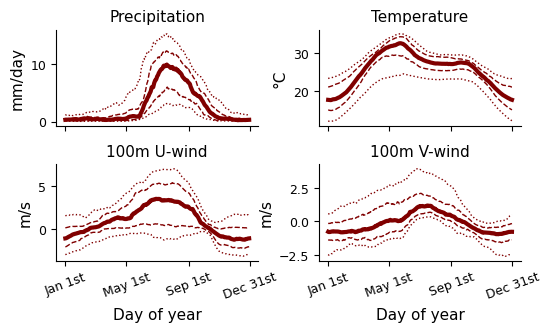

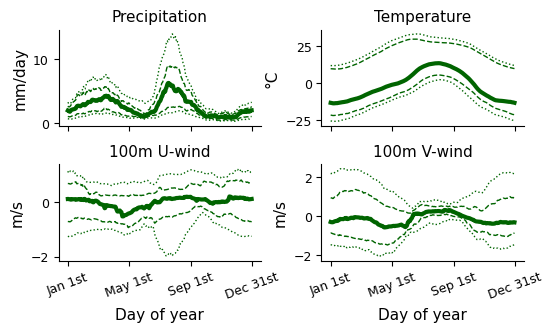

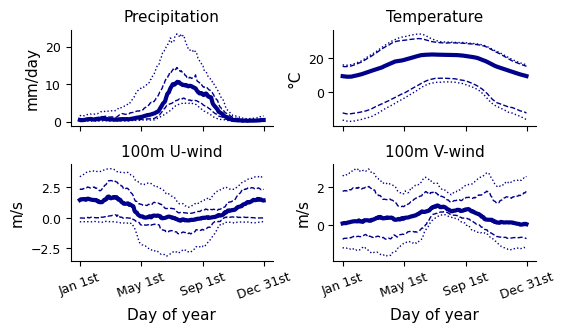

In [8]:
for boundaries, name, color in zip( [country_boundary, HKKH[HKKH.short_name=='hkk'], HKKH[HKKH.short_name=='him']],
                                    ['India', 'Hindu-Kush Karakoram', 'Himalaya'],
                                    ['maroon', 'darkgreen', 'darkblue'] ):


    fig, axs = plt.subplots(2, 2, figsize=(6, 3), sharex=True)
    plt.subplots_adjust(left=None, right=None, top=None, bottom=None, wspace=0.3, hspace=0.4)

    for dataset, ax in zip ([precipitation_data_monthly, temperature_data_monthly, u_wind_100_data_monthly, v_wind_100_data_monthly], axs.flatten()):
        dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        dataset.rio.write_crs("epsg:4326", inplace=True)

        # Plotting for India
        dataset = dataset.rio.clip(boundaries.geometry.apply(mapping), boundaries.crs, drop=True)
        dataset.quantile([0.5],dim=['lat', 'lon']).plot(ax = ax, color=color, lw=3, label='India')
        dataset.quantile([0.1], ['lat', 'lon']).plot(ax = ax, color=color, lw=1, ls=':')
        dataset.quantile([0.9], ['lat', 'lon']).plot(ax = ax, color=color, lw=1, ls=':')
        dataset.quantile([0.25], ['lat', 'lon']).plot(ax = ax, color=color, lw=1, ls='--')
        dataset.quantile([0.75], ['lat', 'lon']).plot(ax = ax, color=color, lw=1, ls='--')

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.grid(False)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    lev = [1, 122, 245, 366]
    axs[1][0].set_xticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev], rotation=20, fontsize=9)
    axs[1][1].set_xticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev], rotation=20, fontsize=9)

    axs[1][0].set_xlabel('Day of year', fontsize=11)
    axs[1][1].set_xlabel('Day of year', fontsize=11)

    axs[0][0].set_ylabel('mm/day', fontsize=11)
    axs[0][1].set_ylabel('°C', fontsize=11)
    axs[1][0].set_ylabel('m/s', fontsize=11)
    axs[1][1].set_ylabel('m/s', fontsize=11)

    # Add text box with name of the variable in each subplot
    for ax, v_name in zip(axs.flatten(), ['Precipitation', 'Temperature', '100m U-wind', '100m V-wind']):
        ax.set_title(v_name, fontsize=11)

    #fig.suptitle(name, fontsize=13, y=1.01)